# Process data methode

___
This notebook aims to explain how measurements from a representative snow pit were processed from raw data to a concatenated profile.
___

### Table of contents:

* I/ General informations about the campaign
* II/ Density process
* III/ Liquid Water Content process
* IV/ Specific Surfaces Area
* V/ Intercomparaison file:

In [1]:
from watermark import watermark # Python env
%load_ext watermark
print (watermark())

Last updated: 2025-06-23T12:09:58.611199+00:00

Python implementation: CPython
Python version       : 3.12.8
IPython version      : 8.17.2

Compiler    : GCC 13.3.0
OS          : Linux
Release     : 6.8.0-58-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit



In [2]:
# ================ IMPORTATIONS ================ #

### DATA MANIPULATION ###

import pandas as pd # used to manipulate 2D data into the data-frame

import numpy as np # useful to handle matrix like datasets

### DATA REPRESENTATION ###

import matplotlib.pyplot as plt # used for makings nice plots

### PERSONAL SCRIPT ###

import sys
import os

# Add the notebook's parent directory to sys.path
sys.path.append(os.path.abspath("../"))

from scripts.Comput import comput_density # To comput density from snow cutter measurments
from scripts.Comput import Comput_LWC #To comput LWC from density and permittivity measurments

from utils.Plot import plot_density_profile
from utils.Plot import plot_LWC
from utils.Plot import plot_multiple_days
from utils.utils import create_profile 
%watermark --iversions

numpy     : 2.0.2
watermark : 2.5.0
matplotlib: 3.10.0
sys       : 3.12.8 | packaged by conda-forge | (main, Dec  5 2024, 14:24:40) [GCC 13.3.0]
pandas    : 2.2.3



# I/ Field campaign at Col du Lautaret 2024-2025:
![Lautaret.jpg](attachment:dd16fe97-a7fa-4889-91a8-b2cdbd885f24.jpg)
Manual snow pit profiles were conducted on March 17, 21, 31, April 1, 2, and 8,
to complement the autonomous measurements with point-scale observations of snow
physical properties representative of the snowpack state at the time of measurement.

## I.1 General terminology:
Each CSV file is first labeled by the variable and then by the date, like: `permitivity_profile_2025-04-08_13h00`

In [3]:
# Here we will treat the data of 21-03-2025
data_folder = "~/private-storage/Data_internship_2025_GP/Campaign_CdL_2024-2025/Lautaret_2025-04-08/data/"

## I.2 Raw data:

For each snow pit, depending on the measuring day, measurements of density profile, permittivity, and specific surface area were performed.
____
### Density
A density cutter was used to measure density. The physical principle is to measure the mass of a certain volume of snow. From this, density can be retrieved with  
$\rho = \frac{m}{v}$  
with $m$: mass, $v$: volume, and $\rho$: density.  
Generally, density was measured every 5 cm along the snow profile. To measure density, only the weight of the snow cutter (empty and full of snow) was recorded in the CSV.  
All measurements were stored in a CSV file named **"Cutter_weight_profile_date"**
____
### Permittivity
Permittivity was measured with the WISe sensor every 10 cm. The permittivity profile was stored in a CSV file named **"permitivity_profile_date"**
____
### Specific Surface Area (SSA)
SSA was measured by ASSSAP. On most field days, only non-continuous profiles were measured every 10 cm.  
Data was first processed with Possum, which finally gives the SSA mean along the sample and the standard deviation.  
SSA data are stored in **"ssa_profile_date"**
____
![Instrument_rapport .jpg](attachment:c6062b9a-ef3b-4e12-bc78-80c61ad590b4.jpg)

# II Density process
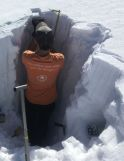
## II.1/ Protocole.
* Weight the empty snow cutter
* Weight the full snow cutter
* Repeat the processed
* 
## II.2/ Quality of mesurment.
First import csv file
Seconde soustract with weight of snowwcutter empty
Finnaly comput :
$$\rho = \frac{m}{v}$$ 
with :
* $m [kg/m^3]$
* $v [m^3]$ here $°0,25e10^-3 m^3$

Process done by comput_density function

In [4]:
# Import of CSV file.
file_name = "Cutter_weight_profile_2025-04-08_9h30.csv"
df_density_9h30 = pd.read_csv(data_folder+file_name, delimiter=';')

# General value 
w_sc=0.442 # Empty snow cutter weight



df_density_9h30 = comput_density(df= df_density_9h30, 
                                 column_name = 'Cutter_weight_[g]',
                                 w_sc=0.442)


<function utils.Plot.plot_density_profile(df_density, thickness)>

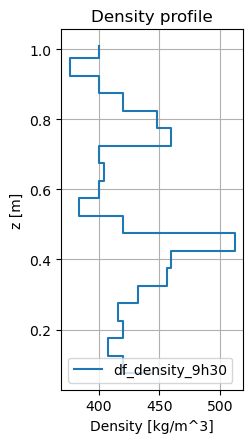

In [5]:
plot_density_profile(df_density_9h30, thickness=1.02)
plot_density_profile

# III Liquid Water Content:
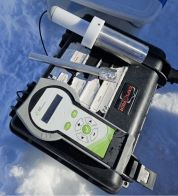

## III.1 Protocol and recomandation

The principle of measurement is easy, nevertheless some precaution is needed. If the WISe sensor is thermals by the air, it will directly affect the result, for instance if the sensor temperature is positive, it will likely melt the snow and then increase the permittivity. Pack down the sample will also increase the density which will increase the permittivity. On the contrary, if the insertion is not total some air at the end of the sensor will reduce a lot the permittivity. To conclude the major source of error is sensor insertion. For this study, all precaution was taken from this point. 

Because we don't control all this insertion process, for the next melt season, for each snow pit at each depth, three samples will be measured.
## III.1 Ambach relation

We want to compute this empirical relation, which is derived from **AMBACH (1980)** and used in the WISe sensor:

$$ \epsilon = 1 + 1.202(𝐷 − 𝑊_𝑣) + 0.983(𝐷 − 𝑊_𝑣)^2 + 21.3𝑊_𝑣 $$

- D in [g/cm³]  
- Wv in [cm³/cm³]  
- LWC Vol = [Wv * 100 %] (percentage of snow volume occupied by liquid water)  
- LWC Mass = [Wv * 1/D] (percentage of total mass due to liquid water)

In practice, the instrument performs the following iteration to compute 𝑊𝑣:

$𝑊_𝑣 = 0$

Repeat 5 times:

$D_s = 𝐷 - 𝑊_𝑣$

$𝑊_𝑣 = (\epsilon - 1 – 1.202D_s – 0.983D_s²)/21.3$

This is done by the **Ambach_Dent()** function.

## III.2 Computation

To compute LWC, each permittivity value must be associated with the closest corresponding density value.  
This is done by the **Comput_LWC()** function.

## III.3 Instance:

In [6]:
# Creat a data frame with all measures.
file_name = "permitivity_profile_2025-04-08_9h30.csv"
df_LWC_profile_9h30 = pd.read_csv(data_folder+file_name, delimiter=';')

df_LWC_profile_9h30 = Comput_LWC(df_LWC_profile = df_LWC_profile_9h30,
                                 df_density = df_density_9h30,
                                 column_name_density = 'density [kg/m3]',
                                 column_name_permitivity = 'Permitivity')

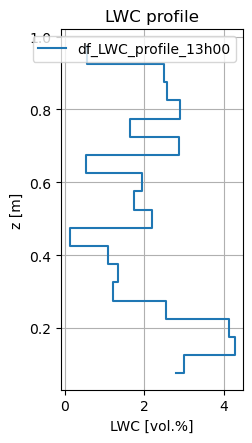

In [7]:
plot_LWC(df_LWC_profile_9h30,
         thickness = 1.02)

# IV Specific surface area profile.
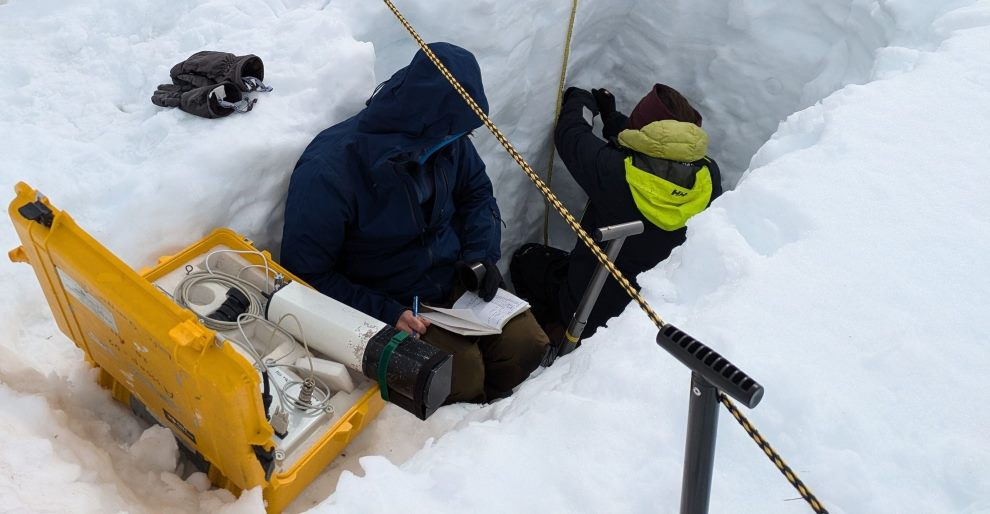
## V.1/ Protocole and recomandation.

**Protocol ASSAp Sample** : 

**Protocol ASSAp Profile**: \
The drilling most be protected from the sun by the maximum of protection. If the protection is well installed the first 10 cm are useful.
Assap take as reference for depth, the surface of snow pack. It measures reflectance at the discount and also at ascent. Because in the drilling some spatial variability exists, two profile was measured for each drilling. If clues highlight that one pass is mediocre, the pass is removed.


As for WISe Sensor, the major source of incertitude is the technical mean of sample. If the sample has some asperities or are two or not full, the SSA output will be useless. For each sample a comment about the SSA quality was written. But at some point, when the insertion of the sampler is difficult, for example when refreshing crust is present it can be difficult to insert the sampler into the snow.
ASSAP integrate some calibration for correct the sensitivity of electronic to temperature. To control that the calibration chose is accurate, each measurement day is first started with the sample of spectralon wallaby 20% and 50% reflectance.

## IV.2/ Processing data

SSA profile is just raw data, the first 10 cm are useless because of the light penetration into the snow, which create reflection which perturb the sensor. If the sensor is well protected from incidence sun flux, the first 10 cm can be conserved.

The mean at a given depth of SSA representative of each pass ascent and descent, which is statistically more representative of the SSA profile is calcul.

Finally, for each SSA profile with assap, two samples, one at the surface the other at -15cm was taken to verify the coherence of the mesurment.


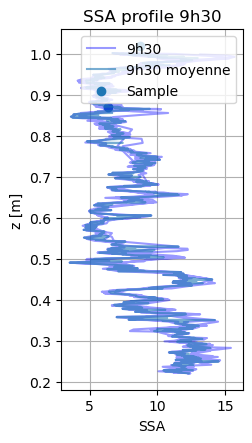

In [8]:
# Definition profil of snow cutter weight with snow IMPORT CSV FILE
file_name = "ssa_profile_2025-04-08_9h30"
df_SSA_profile_9h30 = pd.read_csv(data_folder+file_name, delimiter=' ',names=["Z", "SSA_avg"],skiprows=2)

# Deleate first 10 cm
df_SSA_profile_9h30 = df_SSA_profile_9h30[df_SSA_profile_9h30['Z'] <= -0.10]

# Mean of Z and take the reference as ground and not surface
df_SSA_profile_9h30['Z'] = (df_SSA_profile_9h30['Z'] + 1.102)*1e2
ssa_moyenne_par_Z_2 = df_SSA_profile_9h30.groupby('Z')['SSA_avg'].mean().reset_index()

# Import off ssa sample at surface and -15cm from the surface
file_name = "ssa_surface_2025-04-08_9h30"
df_SSA_surface_9h30 = pd.read_csv(data_folder+file_name, delimiter=',')
df_SSA_surface_9h30["Z"] = np.array([102,102,87,87])
# 2 samples by depth
df_SSA_surface_9h30 = df_SSA_surface_9h30.groupby('Z')['SSAALL'].mean().reset_index()


# Plot SSA profile
fig, ax = plt.subplots(1,1,figsize=(2.34,2*2.34 ))
ax.plot(df_SSA_profile_9h30['SSA_avg'], df_SSA_profile_9h30['Z']*1e-2, color= "b", alpha=0.4 ,label="9h30")
ax.plot(ssa_moyenne_par_Z_2['SSA_avg'], ssa_moyenne_par_Z_2['Z']*1e-2 ,label="9h30 moyenne",alpha=0.6)
ax.scatter(df_SSA_surface_9h30['SSAALL'], df_SSA_surface_9h30['Z']*1e-2 ,label="Sample")

ax.set_xlabel('SSA')
ax.legend()
ax.set_ylabel('z [m]')
ax.set_title("SSA profile 9h30")
ax.grid()
#ax.set_ylim(-,0)

In [9]:
df_SSA_profile_9h30 = df_SSA_profile_9h30.groupby('Z')['SSA_avg'].mean().reset_index()

# V/ Intercomparison file.

Here, a profile is created by taking the more accurate profile between SSA profile LWC profile and density profile as depth reference. Each depth is matched with the closest depth of other profile. For instance, SSA profile as the finest definition profile. LWC and density are matched at each depth of SSA profile. The profile created is then saved in a folder which merges all the snow pit.



In [10]:
data_folder = '~/private-storage/Experiences/Lautaret/Lautaret_concatenate-data/'

# 9H30
df_final = create_profile(df_density=df_density_9h30,
                          df_LWC_profile=df_LWC_profile_9h30,
                          df_SSA_profile=df_SSA_profile_9h30)
file_name = 'concatenate-data_cdl_2025-04-08_9h30.csv'
df_final.to_csv(data_folder +file_name, index=False)

### Visualisation.

This is the final overview of the profile which is used after along this study.

[<Axes: > <Axes: > <Axes: >]


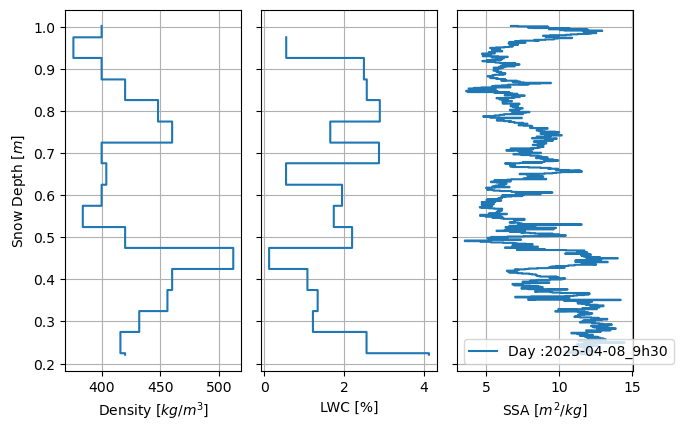

In [11]:
# DATA folder
Date = ["2025-04-08_9h30" ]
# Création of a dic which store each df of a coresponding day

Dic_df_days = {"2025-04-08_9h30" : df_final}
fig,ax=plot_multiple_days(Date,Dic_df_days)